# Climate forcing data

Now that we have all the static data, we can focus on the **climate variables**. In this notebook we will...

1. ...download **ERA5 land reanalysis data** aggregated to our catchment,
2. ...and determine the **reference altitude** of the data from the geopotential height.

For data preprocessing and download we will again use the **Google Earth Engine** (GEE) to offload as much as possible to external servers. ERA5-Land is the latest reanalysis dataset from the European Center for Medium-Range Weather Forecast ([ECMWF](https://www.ecmwf.int/en/era5-land)), available from 1950 to near real-time. The GEE data catalog summarizes...

> ERA5-Land is a reanalysis dataset providing a consistent view of the evolution of land variables over several decades at an enhanced resolution compared to ERA5. ERA5-Land has been produced by replaying the land component of the ECMWF ERA5 climate reanalysis. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using the laws of physics. Reanalysis produces data that goes several decades back in time, providing an accurate description of the climate of the past.
>
> Source: [GEE Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_RAW#description)

To get started we read some settings from the `config.ini` file again:

- **cloud project** name for the GEE access
- **input/output folders** for data imports and downloads
- **filenames** (DEM, GeoPackage)
- include future **projections** or not
- show/hide **interactive map** in notebooks

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)     # Suppress Deprecation Warnings
import pandas as pd
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get file config from config.ini
cloud_project = config['CONFIG']['CLOUD_PROJECT']
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
dir_figures = config['FILE_SETTINGS']['DIR_FIGURES']
output_gpkg = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
scenarios = config.getboolean('CONFIG', 'PROJECTIONS')
show_map = config.getboolean('CONFIG','SHOW_MAP')
zip_output = config['CONFIG']['ZIP_OUTPUT']

# get style for matplotlib plots
plt_style = ast.literal_eval(config['CONFIG']['PLOT_STYLE'])

...and **initialize** the GEE API.

In [2]:
import ee

try:
    ee.Initialize(project=cloud_project)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

We can now load the catchment outline from the previous notebook and convert it to a `ee.FeatureCollection` to use it in GEE.

In [3]:
import geopandas as gpd
import geemap

catchment_new = gpd.read_file(output_gpkg, layer='catchment_new')
catchment = geemap.geopandas_to_ee(catchment_new)

## Set the date range

If you are only interested in modeling the past, set `PROJECTIONS=False` in the `config.ini` to only download reanalysis data for your defined modeling period. Otherwise, all available historical data (since 1979) is downloaded to provide the best possible basis for bias adjustment of the climate scenario data.

In [4]:
if scenarios == True:
    date_range = ['1979-01-01', '2025-01-01']
else:
    date_range = ast.literal_eval(config['CONFIG']['DATE_RANGE'])

print(f'The selected date range is {date_range[0]} to {date_range[1]}')

The selected date range is 1979-01-01 to 2025-01-01


***

## ERA5L Geopotential height

The **reference surface elevation** of ERA5-Land grid cells cannot be obtained directly, but must be calculated from the **geopotential**.

> This parameter is the gravitational potential energy of a unit mass, at a particular location, relative to mean sea level. It is also the amount of work that would have to be done, against the force of gravity, to lift a unit mass to that location from mean sea level.
>
> The geopotential height can be calculated by dividing the geopotential by the Earth's gravitational acceleration, g (=9.80665 m s-2). The geopotential height plays an important role in synoptic meteorology (analysis of weather patterns). Charts of geopotential height plotted at constant pressure levels (e.g., 300, 500 or 850 hPa) can be used to identify weather systems such as cyclones, anticyclones, troughs and ridges.
>
> At the surface of the Earth, this parameter shows the variations in geopotential (height) of the surface, and is often referred to as the orography.
>
> Source: [ECMWF Parameter Database](https://codes.ecmwf.int/grib/param-db/?id=129)

Since the ERA5 geopotential height is not available in the GEE Data Catalog, we downloaded it using the ECMWF Copernicus Data Store ([CDS](https://cds.climate.copernicus.eu/#!/home)) API, converted it to `.ncdf` format, and reuploaded it. Therefore, the file has to be accessed in a similar way to the ice thickness data in Notebook 1.

In [5]:
from resourcespace import ResourceSpace

# use guest credentials to access media server 
api_base_url = config['MEDIA_SERVER']['api_base_url']
private_key = config['MEDIA_SERVER']['private_key']
user = config['MEDIA_SERVER']['user']

myrepository = ResourceSpace(api_base_url, user, private_key)

# get resource IDs for each .zip file
refs_era5l = pd.DataFrame(myrepository.get_collection_resources(128))[['ref', 'file_size', 'file_extension', 'field8']]
ref_geopot = refs_era5l.loc[refs_era5l['field8'] == 'ERA5_land_Z_geopotential']
print("Dataset file and reference on media server:\n")
display(ref_geopot)

Dataset file and reference on media server:



,ref,file_size,file_extension,field8
0,27215,8062521,zip,ERA5_land_Z_geopotential


The `.ncdf` file is then unzipped and loaded as `xarray` dataset for further processing.

In [6]:
from zipfile import ZipFile
import io
import xarray as xr

content = myrepository.get_resource_file(ref_geopot.at[0,'ref'])
with ZipFile(io.BytesIO(content), 'r') as zipObj:
    # Get a list of all archived file names from the zip
    filename = zipObj.namelist()[0]
    print(f'Reading file "{filename}"...')
    file_bytes = zipObj.read(filename)

# Open the file-like object as an xarray dataset
ds = xr.open_dataset(io.BytesIO(file_bytes))
print(f'Dataset contains {ds.z.attrs["long_name"]} in {ds.z.attrs["units"]} as variable \'{ds.z.attrs["GRIB_cfVarName"]}\'')

Reading file "ERA5_land_Z_geopotential.nc"...
Dataset contains Geopotential in m**2 s**-2 as variable 'z'


The original dataset covers the entire globe, so we crop it to the catchment area plus a 1° buffer zone.

In [7]:
# get catchment bounding box with buffer
bounds = catchment_new.total_bounds
min_lon = bounds[0] - 1
min_lat = bounds[1] - 1
max_lon = bounds[2] + 1
max_lat = bounds[3] + 1

cropped_ds = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
print(f"xr.Dataset cropped to bbox[{round(min_lon, 2)}, {round(min_lat, 2)}, {round(max_lon, 2)}, {round(max_lat)}]")

xr.Dataset cropped to bbox[77.06, 41.05, 79.33, 43]


To load `xarray` data into GEE a little workaround is needed. Credits to [Oliver Lopez](https://github.com/lopezvoliver/geemap/blob/netcdf_to_ee/geemap/common.py#L1776) for this solution.

In [8]:
# function to load nc file into GEE
import numpy as np

def netcdf_to_ee(ds):
    data = ds['z']

    lon_data = np.round(data['lon'], 3)
    lat_data = np.round(data['lat'], 3)

    dim_lon = np.unique(np.ediff1d(lon_data).round(3))
    dim_lat = np.unique(np.ediff1d(lat_data).round(3))

    if (len(dim_lon) != 1) or (len(dim_lat) != 1):
        print("The netCDF file is not a regular longitude/latitude grid")
    
    print("Converting xarray to numpy array...")
    data_np = np.array(data)
    data_np = np.transpose(data_np)

    # Figure out if we need to roll the data or not
    # (see https://github.com/giswqs/geemap/issues/285#issuecomment-791385176)
    if np.max(lon_data) > 180:
        data_np = np.roll(data_np, 180, axis=0)
        west_lon = lon_data[0] - 180
    else:
        west_lon = lon_data[0]
    
    print("Saving data extent and origin...")
    transform = [dim_lon[0], 0, float(west_lon) - dim_lon[0]/2, 0, dim_lat[0], float(lat_data[0]) - dim_lat[0]/2]
    
    print("Converting numpy array to ee.Array...")
    image = geemap.numpy_to_ee(
        data_np, "EPSG:4326", transform=transform, band_names='z'
    )
    print("Done!")
    return image, data_np, transform


image, data_np, transform = netcdf_to_ee(cropped_ds)

Converting xarray to numpy array...
Saving data extent and origin...
Converting numpy array to ee.Array...
Done!


If mapping is enabled in the `config.ini` you can now display the **geopotential** data in the **GEE map**. <a id="map"></a>

In [9]:
import geemap.colormaps as cm

if show_map:
    Map = geemap.Map()
    # add geopotential as layer
    vis_params =  {'min': int(data_np.min()), 'max': int(data_np.max()), 'palette': cm.palettes.terrain, 'opacity': 0.8}
    Map.addLayer(image, vis_params, "ERA5L geopotential")
    
    # add catchment
    Map.addLayer(catchment, {'color': 'darkgrey'}, "Catchment")
    Map.centerObject(catchment, zoom=9)
    display(Map)
else:
    print("Map view disabled in config.ini")        

Map(center=[42.182797129005124, 78.18973871888807], controls=(WidgetControl(options=['position', 'transparent_…

Since our workflow will use a **lumped model**, we will use **area-weighted catchment-wide averages** of our forcing data. Thus, we also aggregate the geopotential based on the grid cell fractions in the catchment and convert it to **geopotential height in meters above sea level**. This represents the **reference altitude of our forcing data**, just as the elevation of a weather station would.

In [10]:
# execute reducer
dict = image.reduceRegion(ee.Reducer.mean(),
                          geometry=catchment,
                          crs='EPSG:4326',
                          crsTransform=transform)

# get mean value and print
mean_val = dict.getInfo()['z']
ele_dat = mean_val / 9.80665
print(f'Geopotential mean:\t{mean_val:.2f} m2 s-2\nElevation:\t\t {ele_dat:.2f} m a.s.l.')

Geopotential mean:	32711.74 m2 s-2
Elevation:		 3335.67 m a.s.l.


***

## ERA5-Land Temperature and Precipitation Data

Our model only requires **temperature and precipitation** as inputs. We will download both time series from the **ERA5-Land Daily Aggregated - ECMWF Climate Reanalysis** `ECMWF/ERA5_LAND/DAILY_RAW` dataset in the <a href="https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_RAW#bands">Google Earth Engine Data Catalog</a>

> The asset is a daily aggregate of ECMWF ERA5 Land hourly assets. [...] Daily aggregates have been pre-calculated to facilitate many applications requiring easy and fast access to the data.
>
> Source: [GEE Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_RAW#description)

On the server side, we simply create an `ee.ImageCollection` with the desired bands (temperature and precipitation) and date range. To calculate area-weighted aggregates we apply the `ee.Reducer` function.

In [11]:
import pandas as pd
import datetime

def setProperty(image):
    dict = image.reduceRegion(ee.Reducer.mean(), catchment)
    return image.set(dict)


collection = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_RAW')\
    .select('temperature_2m','total_precipitation_sum')\
    .filterDate(date_range[0], date_range[1])

withMean = collection.map(setProperty)

We can then aggregate the results into arrays, download them with `.getInfo()` and store them as dataframe columns. Depending on the selected date range and server traffic this can take up to a few minutes.

In [12]:
%%time

df = pd.DataFrame()
print("Get timestamps...")
df['ts'] = withMean.aggregate_array('system:time_start').getInfo()
df['dt'] = df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000))
print("Get temperature values...")
df['temp'] = withMean.aggregate_array('temperature_2m').getInfo()
df['temp_c'] = df['temp'] - 273.15
print("Get precipitation values...")
df['prec'] = withMean.aggregate_array('total_precipitation_sum').getInfo()
df['prec'] = df['prec'] * 1000

Get timestamps...
Get temperature values...
Get precipitation values...
CPU times: user 233 ms, sys: 3.28 ms, total: 236 ms
Wall time: 1min 42s


The constructed data frame now looks like this:

In [13]:
display(df)

,ts,dt,temp,temp_c,prec
0,283996800000,1979-01-01 01:00:00,257.392996,-15.757004,0.027381
1,284083200000,1979-01-02 01:00:00,256.435964,-16.714036,0.004825
2,284169600000,1979-01-03 01:00:00,257.867342,-15.282658,0.001601
3,284256000000,1979-01-04 01:00:00,258.322419,-14.827581,0.283469
4,284342400000,1979-01-05 01:00:00,258.056697,-15.093303,0.108583
...,...,...,...,...,...
16797,1735257600000,2024-12-27 01:00:00,263.114958,-10.035042,0.026132
16798,1735344000000,2024-12-28 01:00:00,259.717669,-13.432331,0.000925
16799,1735430400000,2024-12-29 01:00:00,261.213752,-11.936248,0.005297
16800,1735516800000,2024-12-30 01:00:00,263.517126,-9.632874,1.158257


Let's **plot** the full time series.

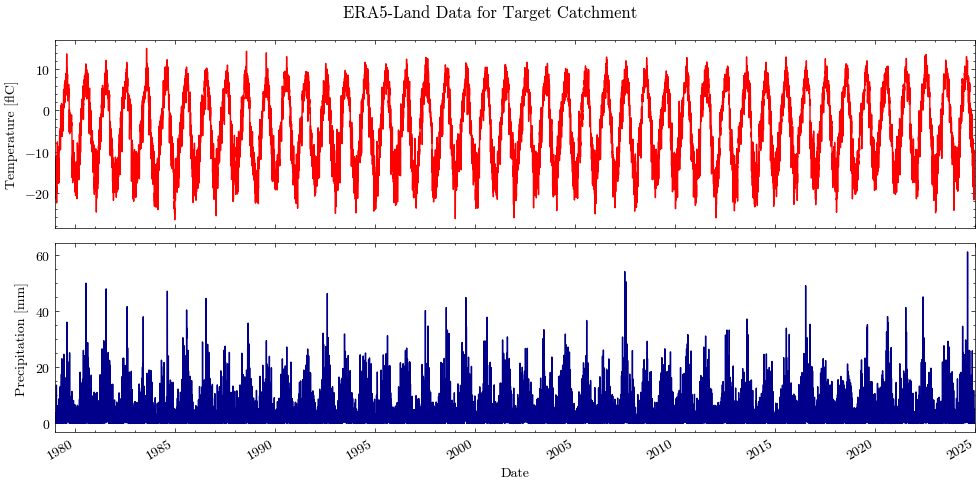

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scienceplots

# set style from config
plt.style.use(plt_style)

axes = df.drop(['ts','temp'],axis=1).plot.line(x='dt', subplots=True, legend=False, figsize=(10,5),
                                               title='ERA5-Land Data for Target Catchment',
                                               color={"temp_c": "red", "prec": "darkblue"})
axes[0].set_ylabel("Temperature [°C]")
axes[1].set_ylabel("Precipitation [mm]")
axes[1].set_xlabel("Date")
axes[1].xaxis.set_minor_locator(mdates.YearLocator())
plt.xlim(date_range)
plt.tight_layout()
plt.savefig(dir_figures+'NB2_ERA5_Temp_Prec.png')
plt.show()

## Store data for next steps

To continue in the workflow, we write the ERA5 data to a `.csv` file...

In [15]:
df.to_csv(dir_output + 'ERA5L.csv',header=True,index=False)

...and update the `settings.yml` file with the reference altitude of the ERA5-Land data (`ele_dat`) and refresh `output_download.zip` with newly acquired data.

In [17]:
from tools.helpers import update_yaml
import shutil

# update settings file
update_yaml(dir_output + 'settings.yml', {'ele_dat': float(ele_dat)})

if zip_output:
    # refresh `output_download.zip` with data retrieved within this notebook
    shutil.make_archive('output_download', 'zip', 'output')
    print('Output folder can be download now (file output_download.zip)')

Data successfully written to YAML at output/settings.yml
Output folder can be download now (file output_download.zip)


In [ ]:
%reset -f

You can now continue with [Notebook 3](Notebook3_CMIP6.ipynb).